In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import preprocessing
import seaborn as sns
%matplotlib inline

## Capstone: Predict cardiac mortality w.Logistic Regression
### Depression, with low HRV and high HR in sleep (we use waking measure), predicts high risk of cardiac mortality event, according to research paper*. Confirmed with our data? (NO, SDNN doesn't appear to be a good proxy for mean log HRV.)

HR-HRV + Depression scores will be used to predict heart attack (mi_date) in several ways.

#### HR = instantaneous waking HR >> Paper uses mean nighttime HR measured using func data analysis (Bsplines with 9 basis functions), but this is not measurable by Apple Watch.

#### HRV = waking HRV (SDNN) >> Paper uses mean nighttime log VLF, but this is not measurable by Apple Watch.

Predict whether:

1) Scenario 1 -- Heart attack happened (conclusion: we cannot predict.)

2) Scenario 2 -- ...Within one year

*R. Carney, K. Freedland, B. Steinmeyer, et al. "Nighttime Heart Rate Predicts Response to Depression Treatment In Patients with Coronary Heart Disease," J Affect Disord. 2016 Aug; 200: 165–171. Published online 2016 Apr 25. doi: 10.1016/j.jad.2016.04.051


### Data Processing

We first need to drop the first HRV data for each user, so only waking HRV data (last) is left. 

Then we will turn our heart attack column "mi_date" into a binary classification to see if it is worth using logistic regression to see if we can predict who does, and doesn't get, a myocardial infarction, AKA heart attack (at any time).

After looking at the plots, doesn't seem like this type of ML is going to work. 
The confusion matrix shows it predicted NO heart attack, 95% of time correctly. But it never predicted YES heart attack.

### My hunch: we'll predict heart attacks within one year, if we narrow feature to HR-HRV only. And try looking at all of the HRV data, vs only waking data. (SORRY: NOPE)

#### Options:

Opt 1) Only mark mi_date < 365 (within one year) as a "1" and retry. (Conclusion: no predictions made.)

+

Opt 2) Add in all the rest of HRV data. (Conclusion: no predictions made.)

+

Opt 3) Remove all other data except SDNN and HR-HRV (didn't help)

## Try predicting depression instead.

Create Binary BLUE25 for predictor.

### Other algorithms?

?? This will likely not work > linear regression to see if we can predict the likelihood of cardiac event within various intervals of time: 0-1 years, 1-5 years, 5-10 years.

In [2]:
# Scenario 1 -- Pull in all, incl non-MI people, data with only waking data
df = pd.read_csv('Qmerge1-FirstLastHRV.csv')


In [3]:
df.head()

,nsrrid,gender_x,race_x,age_s1_x,ang_date,chd_dthdt,chf_date,cvd_dthdt,mi_date,stk_date,...,ihr,NN_RR,AVNN,SDNN,VLF,LF,LF_n,HF,HF_n,LF_HF
0,200079,2,3,56,NaN,NaN,NaN,NaN,NaN,NaN,...,75.112951,0.992000,798.797,46.2118,695.63900,285.5300,0.256639,827.046,0.743361,0.345241
1,200079,2,3,56,NaN,NaN,NaN,NaN,NaN,NaN,...,72.227893,0.991713,830.704,51.1569,1890.74140,331.3890,0.389947,518.442,0.610053,0.639202
2,200079,2,3,56,NaN,NaN,NaN,NaN,NaN,NaN,...,72.233893,0.991690,830.635,50.2283,1904.23100,260.8690,0.322499,548.030,0.677501,0.476012
3,200079,2,3,56,NaN,NaN,NaN,NaN,NaN,NaN,...,72.486004,0.997238,827.746,28.6337,42.66966,86.3107,0.129813,578.575,0.870187,0.149178
4,200079,2,3,56,NaN,NaN,NaN,NaN,NaN,NaN,...,77.839184,0.994872,770.820,29.1776,250.20480,331.0160,0.530332,293.152,0.469668,1.129160


In [4]:
# Scenario 1 -- no. of rows.
df.shape[0]

42434

In [5]:
# Scenario 1 -- drop every other row, starting with first row. Leaves only the last HRV measured in visit 1.
df1 = df.drop(df.index[range(0, df.shape[0], 2)])

In [6]:
df1.head()

In [7]:
df1 = df1[['nsrrid', 'gender_x', 'race_x', 'age_s1_x', 'BLUE25', 'DOWN25', 'ql209c','ql209f', 'mi_date', 'SDNN', 'ihr', 'AVNN', 'VLF', 'LF', 'HF']]

In [8]:
# classify whether 1) MI happened (df1); and if so, 2)  within 0-1 years 3)  1-5 years and 4)  5-10 years.
df1.head()

,nsrrid,gender_x,race_x,age_s1_x,BLUE25,DOWN25,ql209c,ql209f,mi_date,SDNN,ihr,AVNN,VLF,LF,HF
0,200079,2,3,56,5.0,6.0,6.0,6.0,NaN,46.2118,75.112951,798.797,695.63900,285.5300,827.046
1,200079,2,3,56,5.0,6.0,6.0,6.0,NaN,51.1569,72.227893,830.704,1890.74140,331.3890,518.442
2,200079,2,3,56,5.0,6.0,6.0,6.0,NaN,50.2283,72.233893,830.635,1904.23100,260.8690,548.030
3,200079,2,3,56,5.0,6.0,6.0,6.0,NaN,28.6337,72.486004,827.746,42.66966,86.3107,578.575
4,200079,2,3,56,5.0,6.0,6.0,6.0,NaN,29.1776,77.839184,770.820,250.20480,331.0160,293.152


In [9]:
# Starting with 'Whether MI Happened', DF1. 
df1 = df1.fillna(value=0)

In [10]:
df1['mi_date'] = df1['mi_date'].astype(bool).astype(int)


In [11]:
# Scenario 2 -- replace only ms_date > 365 with 0.
df1.loc[df1['mi_date'] > 365, 'mi_date'] = 0

In [12]:
df1['HR-HRV'] = df1['ihr'] - df1['SDNN'] 

In [13]:
df1

,nsrrid,gender_x,race_x,age_s1_x,BLUE25,DOWN25,ql209c,ql209f,mi_date,SDNN,ihr,AVNN,VLF,LF,HF,HR-HRV
0,200079,2,3,56,5.0,6.0,6.0,6.0,0.0,46.2118,75.112951,798.797,695.639000,285.5300,827.046,28.901151
1,200079,2,3,56,5.0,6.0,6.0,6.0,0.0,51.1569,72.227893,830.704,1890.741400,331.3890,518.442,21.070993
2,200079,2,3,56,5.0,6.0,6.0,6.0,0.0,50.2283,72.233893,830.635,1904.231000,260.8690,548.030,22.005593
3,200079,2,3,56,5.0,6.0,6.0,6.0,0.0,28.6337,72.486004,827.746,42.669660,86.3107,578.575,43.852304
4,200079,2,3,56,5.0,6.0,6.0,6.0,0.0,29.1776,77.839184,770.820,250.204800,331.0160,293.152,48.661584
5,200079,2,3,56,5.0,6.0,6.0,6.0,0.0,67.4581,80.722846,743.284,2896.047700,1161.1900,343.751,13.264746
6,200079,2,3,56,5.0,6.0,6.0,6.0,0.0,70.7677,76.669772,782.577,2184.741700,2120.3300,540.894,5.902072
7,200079,2,3,56,5.0,6.0,6.0,6.0,0.0,74.8114,78.206261,767.202,4074.880000,1245.1400,402.561,3.394861
8,200079,2,3,56,5.0,6.0,6.0,6.0,0.0,78.0562,76.244985,786.937,4340.239000,1401.3900,519.879,-1.811215
9,200079,2,3,56,5.0,6.0,6.0,6.0,0.0,77.1544,76.026837,789.195,4131.339000,1619.0000,561.124,-1.127563


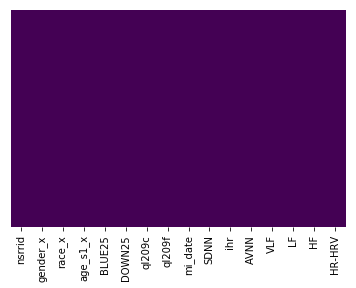

In [14]:
# run logistic regression to classify on mi_date. Let's see if binary classification of heart attack works.
# optional, use lb = preprocessing.LabelBinarizer()

sns.heatmap(df1.isnull(),yticklabels=False,cbar=False,cmap='viridis')

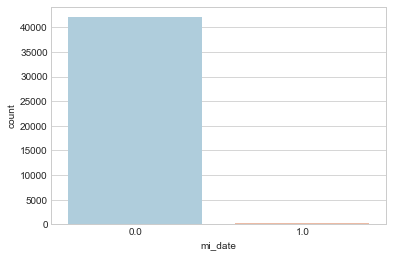

In [15]:
sns.set_style('whitegrid')
sns.countplot(x='mi_date',data=df1,palette='RdBu_r')

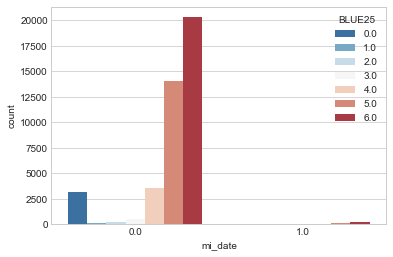

In [16]:
# freq by downhearted and blue past 4 weeks, by heart attack no -- yes
sns.set_style('whitegrid')
sns.countplot(x='mi_date',hue='BLUE25',data=df1,palette='RdBu_r')

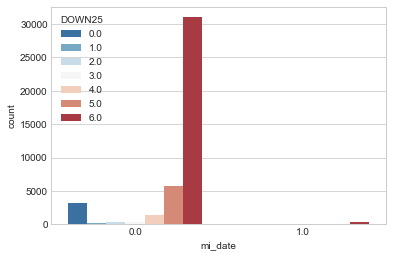

In [17]:
# freq by down in dumps past 4 weeks, by heart attack no -- yes
sns.set_style('whitegrid')
sns.countplot(x='mi_date',hue='DOWN25',data=df1,palette='RdBu_r')

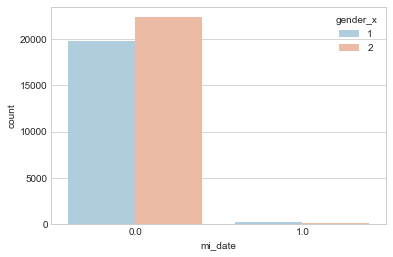

In [18]:
# freq by gender, by heart attack no -- yes
sns.set_style('whitegrid')
sns.countplot(x='mi_date',hue='gender_x',data=df1,palette='RdBu_r')

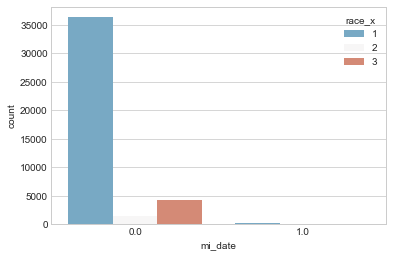

In [19]:
# freq by race, by heart attack no -- yes
sns.set_style('whitegrid')
sns.countplot(x='mi_date',hue='race_x',data=df1,palette='RdBu_r')

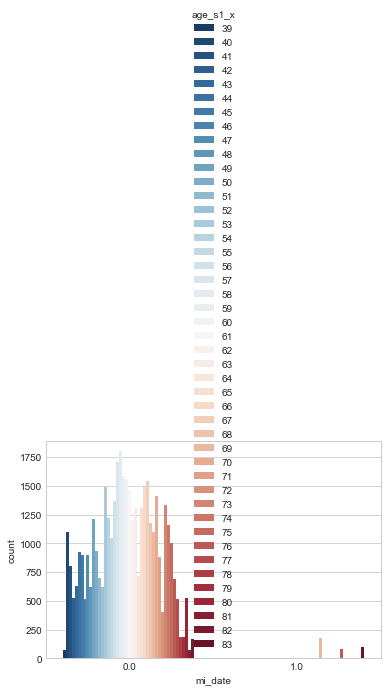

In [20]:
# freq by age, by heart attack no -- yes

sns.set_style('whitegrid')
sns.countplot(x='mi_date',hue='age_s1_x',data=df1,palette='RdBu_r')

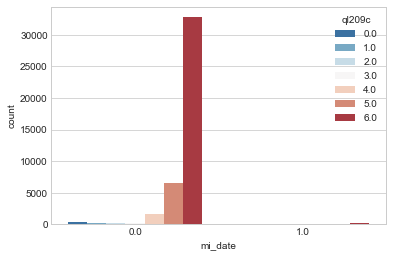

In [21]:
# degree of down in dumps past 4 weeks, by heart attack no -- yes
sns.set_style('whitegrid')
sns.countplot(x='mi_date',hue='ql209c',data=df1,palette='RdBu_r')

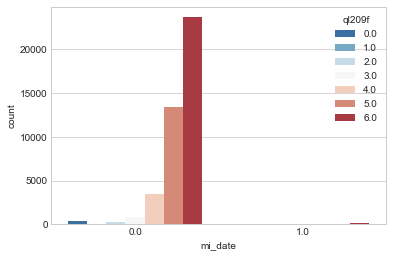

In [22]:
# degree of downhearted/blue past 4 weeks, by heart attack no -- yes
sns.set_style('whitegrid')
sns.countplot(x='mi_date',hue='ql209f',data=df1,palette='RdBu_r')

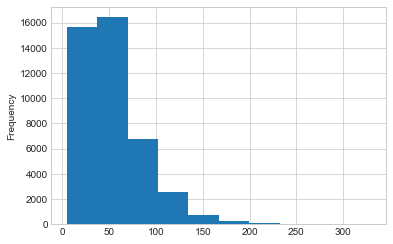

In [23]:
# what waking SDNN looks like, across all patients
df1['SDNN'].plot.hist(bins=10)

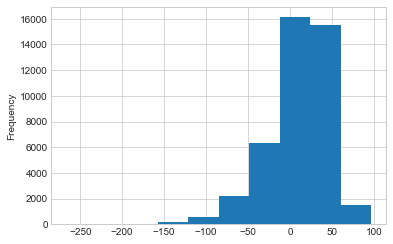

In [24]:
# what waking HR-HRV diff looks like, across all patients
df1['HR-HRV'].plot.hist(bins=10)

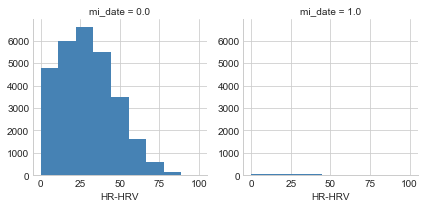

In [25]:
# no. of people with heart attack no -- yes, by 1) level of HR-HRV diff 
g = sns.FacetGrid(df1, col="mi_date", margin_titles=True)
bins = np.linspace(0, 100, 10)
g.map(plt.hist, "HR-HRV", color="steelblue", bins=bins, lw=0)

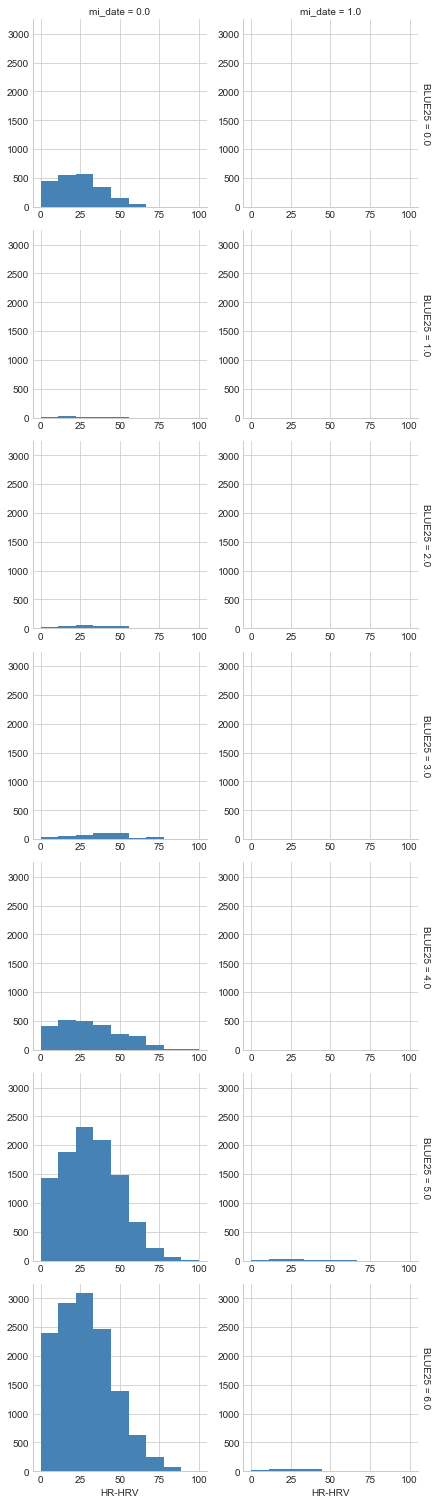

In [26]:
# no. of people with heart attack no -- yes, by 1) level of HR-HRV diff and 2) level of downhearted/blue past 4 weeks

g = sns.FacetGrid(df1, row="BLUE25", col="mi_date", margin_titles=True)
bins = np.linspace(0, 100, 10)
g.map(plt.hist, "HR-HRV", color="steelblue", bins=bins, lw=0)

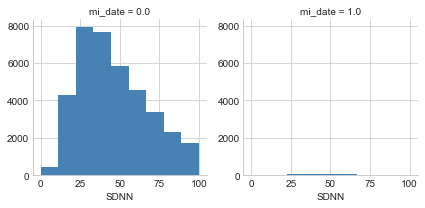

In [27]:
# no. of people with heart attack no -- yes, by 1) level of SDNN 

g = sns.FacetGrid(df1, col="mi_date", margin_titles=True)
bins = np.linspace(0, 100, 10)
g.map(plt.hist, "SDNN", color="steelblue", bins=bins, lw=0)

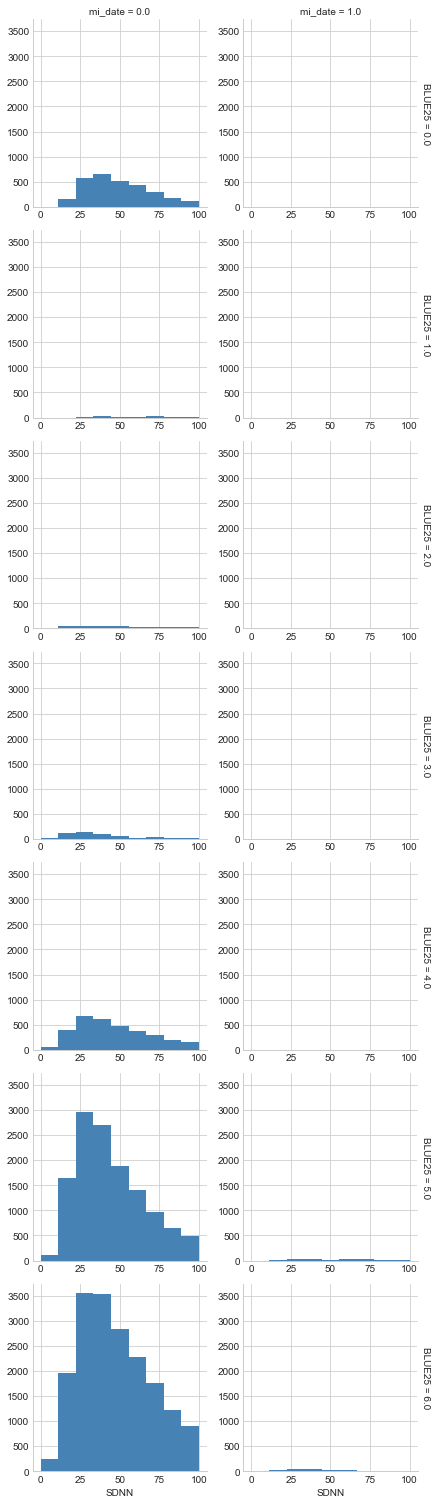

In [28]:
# no. of people with heart attack no -- yes, by 1) level of SDNN and 2) level of downhearted/blue past 4 weeks

g = sns.FacetGrid(df1, row='BLUE25', col="mi_date", margin_titles=True)
bins = np.linspace(0, 100, 10)
g.map(plt.hist, "SDNN", color="steelblue", bins=bins, lw=0)

In [29]:
# X is the feature data eg SDNN and HR-HRV. Y is the data we're predicting, eg mi_date.

X = df1.drop('mi_date', axis = 1)
y = df1['mi_date']

In [30]:
from sklearn.cross_validation import train_test_split

/Users/minan/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)


In [32]:
from sklearn.linear_model import LogisticRegression

In [33]:
logmodel = LogisticRegression()

In [34]:
logmodel.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [35]:
predictions = logmodel.predict(X_test)

In [36]:
from sklearn.metrics import classification_report

In [37]:
print(classification_report(y_test,predictions))

             precision    recall  f1-score   support

        0.0       0.99      1.00      1.00     12609
        1.0       0.00      0.00      0.00       122

avg / total       0.98      0.99      0.99     12731



/Users/minan/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [38]:
from sklearn.metrics import confusion_matrix

In [39]:
confusion_matrix(y_test, predictions)

array([[12609,     0],
       [  122,     0]])